# Imports

In [2]:
!pip install -q sktime[all_extras] optuna dask[dataframe]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.datasets import load_longley, load_macroeconomic
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    make_reduction, TransformedTargetForecaster, ForecastingPipeline,
    RecursiveTabularRegressionForecaster, RecursiveTimeSeriesRegressionForecaster,
    DirectTabularRegressionForecaster, DirectTimeSeriesRegressionForecaster,
    MultiplexForecaster
)
from sktime.forecasting.model_selection import (
    temporal_train_test_split, SlidingWindowSplitter, ExpandingWindowSplitter,
    ForecastingOptunaSearchCV, ForecastingGridSearchCV
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.transformations.compose import ColumnwiseTransformer, TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.forecasting.naive import NaiveVariance
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredPercentageError, MedianAbsolutePercentageError, MeanAbsoluteScaledError
from sktime.performance_metrics.forecasting.probabilistic import (
    PinballLoss, EmpiricalCoverage, AUCalibration, SquaredDistrLoss, LogLoss, CRPS
)
from sktime.utils.plotting import plot_series, plot_windows
from sktime.pipeline import sklearn_to_sktime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
import optuna
from  optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

# Load Data

In [43]:
# Load data
data = load_macroeconomic()

# Display the data
print("Data head:")
display(data.head())

print("\nData tail:")
display(data.tail())

Data head:


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
Period,,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19



Data tail:


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
Period,,,,,,,,,,,,
2008Q3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008Q4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009Q1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009Q2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
2009Q3,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


In [44]:
# Split into X and y
y = data[["unemp"]]
X = data.drop(columns=["unemp"])

In [45]:
# Basic info
print("Data Info:")
data.info()

print("\ny Info:")
y.info()

print("\nX Info:")
X.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 203 entries, 1959Q1 to 2009Q3
Freq: Q-DEC
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realgdp   203 non-null    float64
 1   realcons  203 non-null    float64
 2   realinv   203 non-null    float64
 3   realgovt  203 non-null    float64
 4   realdpi   203 non-null    float64
 5   cpi       203 non-null    float64
 6   m1        203 non-null    float64
 7   tbilrate  203 non-null    float64
 8   unemp     203 non-null    float64
 9   pop       203 non-null    float64
 10  infl      203 non-null    float64
 11  realint   203 non-null    float64
dtypes: float64(12)
memory usage: 20.6 KB

y Info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 203 entries, 1959Q1 to 2009Q3
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   unemp   203 non-null    float64
dtypes: float64(1)
memory usag

In [46]:
# Print shapes
print(f"There are {data.shape[0]} rows in the dataset.")
print(f"There are {data.shape[1]} columns in the dataset.")

There are 203 rows in the dataset.
There are 12 columns in the dataset.


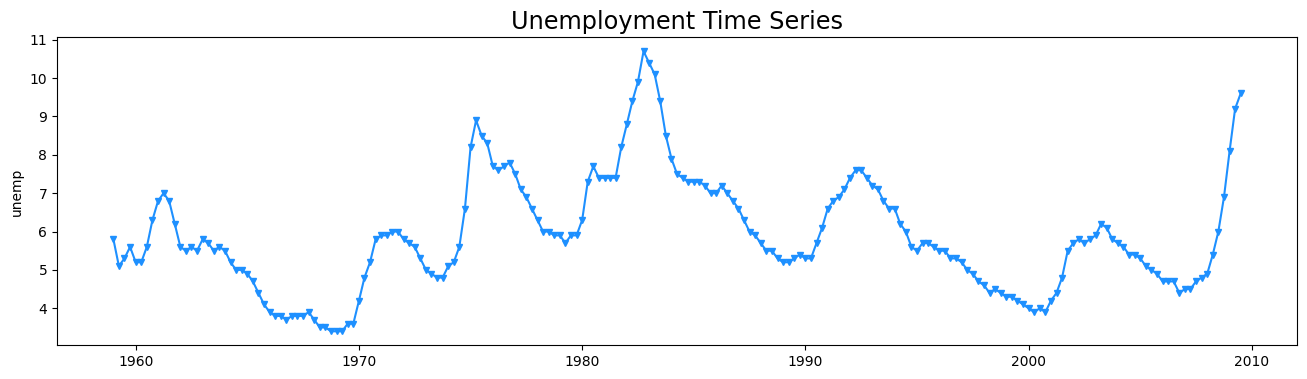

In [ ]:
# Plot the time series
fig, ax = plot_series(y, title="Unemployment Time Series", colors=["dodgerblue"], markers=["v"])
plt.show()

# Split Data

In [48]:
# Split the data
test_size = 20
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=test_size)

In [49]:
# Print shapes
print(f"Shape for y_train: {y_train.shape}")
print(f"Shape for y_test: {y_test.shape}\n")

print(f"Shape for X_train: {X_train.shape}")
print(f"Shape for X_test: {X_test.shape}\n")

# Display the DataFrames
print("DataFrame for y_train:")
display(y_train.head())
print("\n")

print("DataFrame for y_test:")
display(y_test.head())
print("\n")

print("DataFrame for X_train:")
display(X_train.head())
print("\n")

print("DataFrame for X_test:")
display(X_test.head())

Shape for y_train: (183, 1)
Shape for y_test: (20, 1)

Shape for X_train: (183, 11)
Shape for X_test: (20, 11)

DataFrame for y_train:


,unemp
Period,
1959Q1,5.8
1959Q2,5.1
1959Q3,5.3
1959Q4,5.6
1960Q1,5.2




DataFrame for y_test:


,unemp
Period,
2004Q4,5.4
2005Q1,5.3
2005Q2,5.1
2005Q3,5.0
2005Q4,4.9




DataFrame for X_train:


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,pop,infl,realint
Period,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,180.007,2.31,1.19




DataFrame for X_test:


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,pop,infl,realint
Period,,,,,,,,,,,
2004Q4,12410.282,8654.2,2125.152,865.596,9303.4,191.8,1366.6,2.20,294.741,2.09,0.11
2005Q1,12534.113,8719.0,2170.299,869.204,9189.6,193.8,1357.8,2.69,295.308,4.15,-1.46
2005Q2,12587.535,8802.9,2131.468,870.044,9253.0,194.7,1366.6,3.01,295.994,1.85,1.16
2005Q3,12683.153,8865.6,2154.949,890.394,9308.0,199.2,1375.0,3.52,296.770,9.14,-5.62
2005Q4,12748.699,8888.5,2232.193,875.557,9358.7,199.4,1380.6,4.00,297.435,0.40,3.60


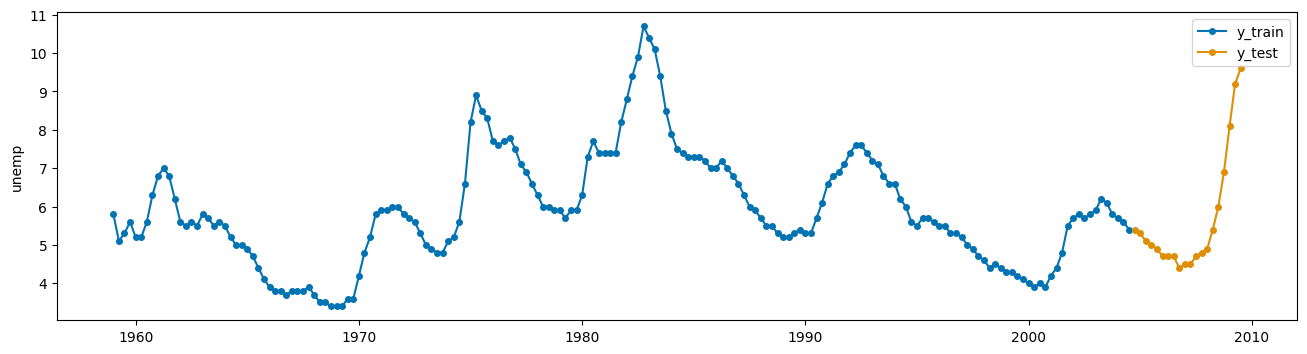

In [ ]:
# Plot the splits
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])
plt.show()

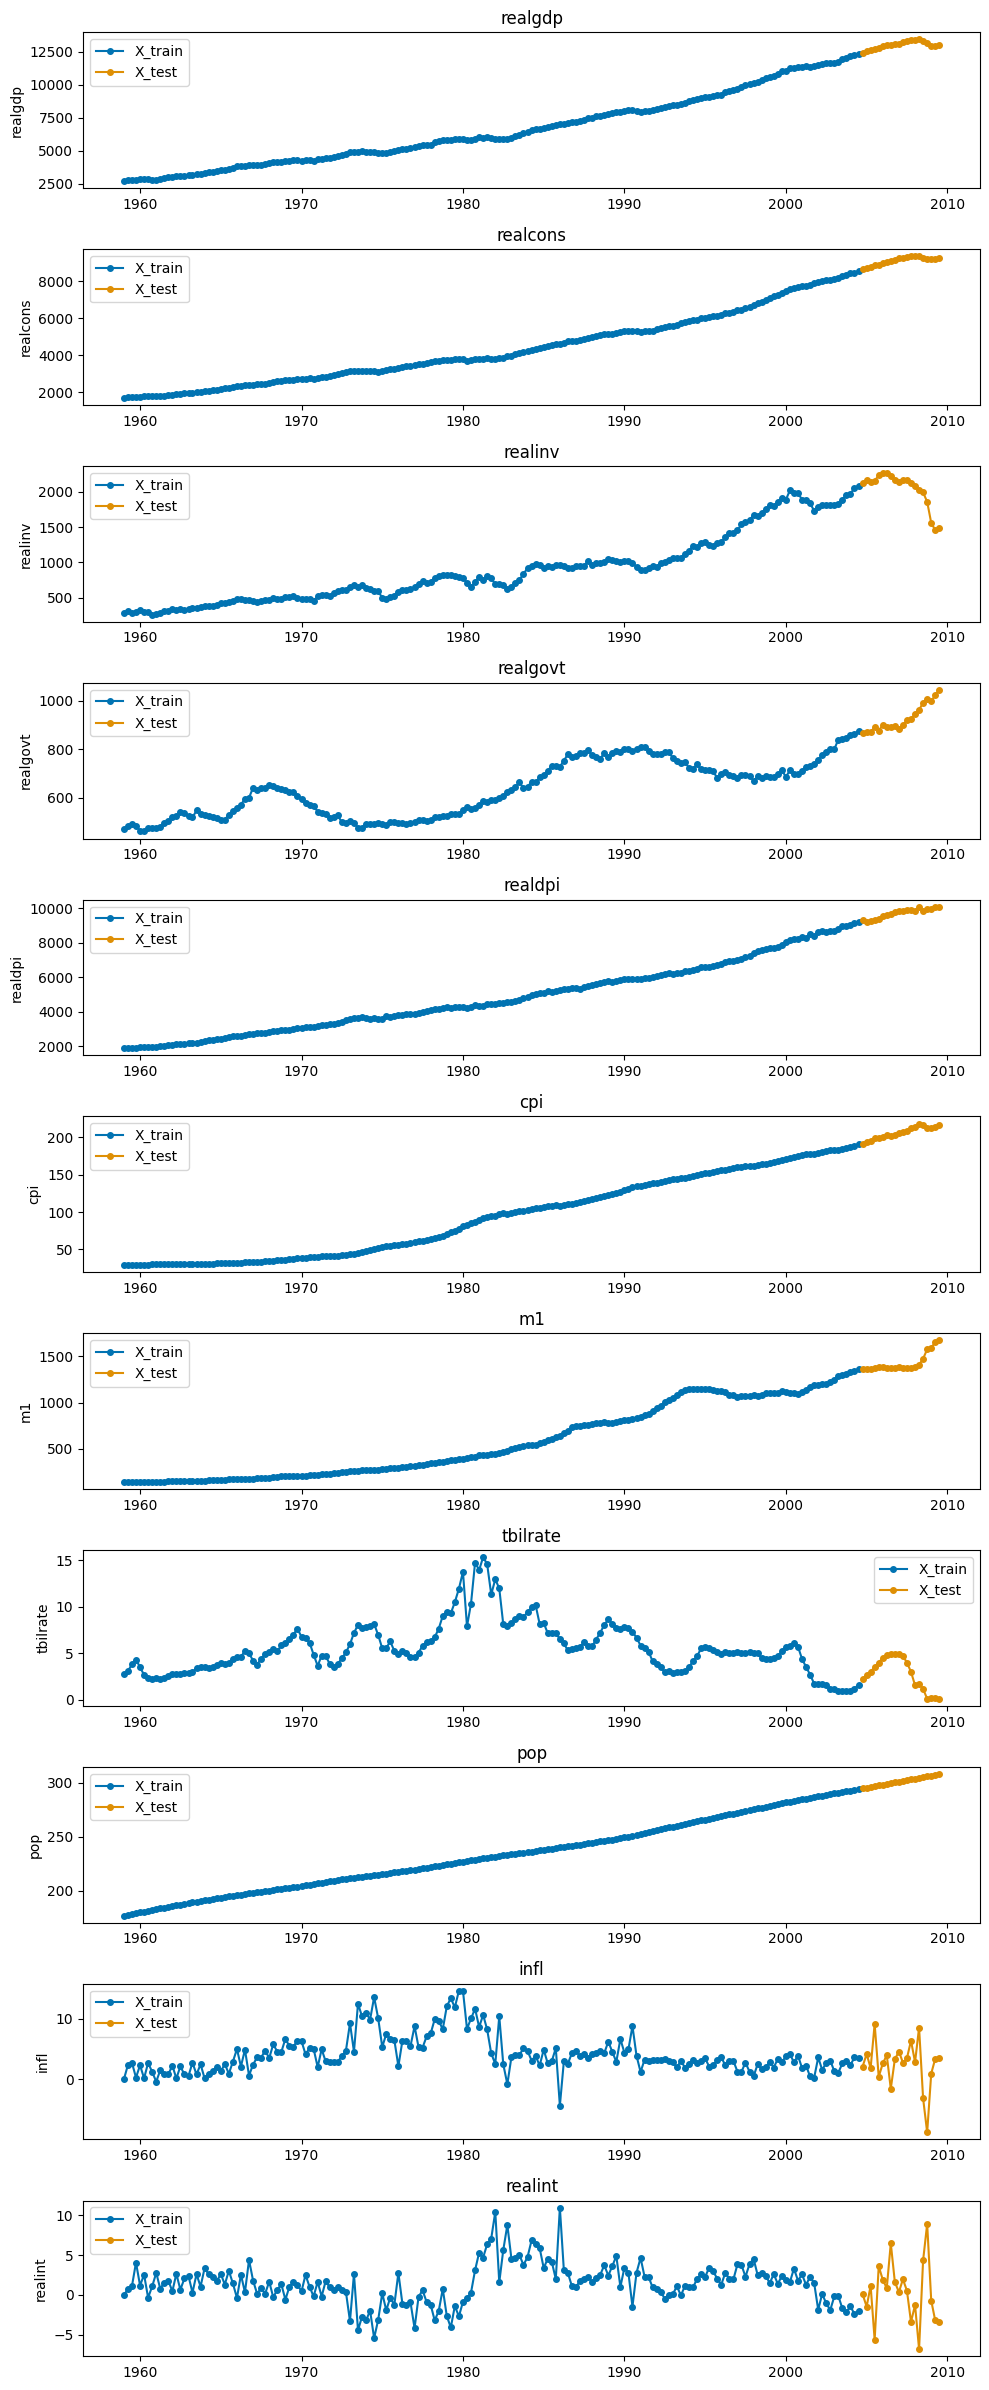

In [ ]:
# Ensure the number of columns are the same for X_train and X_test
assert X_train.shape[1] == X_test.shape[1], "X_train and X_test must have the same number of columns"

# Create a figure and axes for plotting
fig, axs = plt.subplots(X_train.shape[1], 1, figsize=(10, 24), sharex=False)

# Iterate over columns and plot each one
for i, column in enumerate(X_train.columns):
    plot_series(X_train[column], X_test[column], labels=["X_train", "X_test"], ax=axs[i])
    axs[i].set_title(column)

# Show the plot
plt.tight_layout()
plt.show()

# Seasonality, Trend, Stationarity

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from statsmodels.tsa.stattools import adfuller

def decompose_and_plot(y, model='multiplicative', period=4, title="Decomposition"):
    """
    Decompose the time series and plot the decomposition.

    Parameters:
    y (pd.Series): The time series data.
    model (str): The type of seasonal component. Either 'additive' or 'multiplicative'. Default is 'multiplicative'.
    period (int): The number of observations per cycle. Default is 4.
    title (str): The title of the plot. Default is "Decomposition".

    Returns:
    decomposition (DecomposeResult): The decomposition result object.
    """
    y_timestamp = y.to_timestamp()
    decomposition = sm.tsa.seasonal_decompose(y_timestamp, model=model, period=period)
    fig = decomposition.plot()
    plt.suptitle(title)
    plt.show()
    return decomposition

def compare_models(y, period=4):
    """
    Compare additive and multiplicative decomposition models based on Mean Absolute Error (MAE) of the residuals.

    Parameters:
    y (pd.Series): The time series data.
    period (int): The number of observations per cycle. Default is 4.

    Returns:
    model_type (str): The recommended model type ('additive' or 'multiplicative').
    decomposition (DecomposeResult): The decomposition result object for the recommended model.
    """
    y_timestamp = y.to_timestamp()
    additive_decomposition = sm.tsa.seasonal_decompose(y_timestamp, model='additive', period=period)
    additive_resid = additive_decomposition.resid.dropna()
    multiplicative_decomposition = sm.tsa.seasonal_decompose(y_timestamp, model='multiplicative', period=period)
    multiplicative_resid = multiplicative_decomposition.resid.dropna()

    additive_mae = mean_absolute_error(additive_resid, [0]*len(additive_resid))
    multiplicative_mae = mean_absolute_error(multiplicative_resid, [0]*len(multiplicative_resid))

    print(f"\nAdditive MAE: {additive_mae}")
    print(f"Multiplicative MAE: {multiplicative_mae}")

    if additive_mae < multiplicative_mae:
        print("Additive model is recommended.\n")
        return 'additive', additive_decomposition
    else:
        print("Multiplicative model is recommended.\n")
        return 'multiplicative', multiplicative_decomposition

def apply_deseasonalizer(y_train, y_test, model='additive', sp=4):
    """
    Apply deseasonalization to the training and test time series data.

    Parameters:
    y_train (pd.Series): The training time series data.
    y_test (pd.Series): The test time series data.
    model (str): The type of seasonal component. Either 'additive' or 'multiplicative'. Default is 'additive'.
    sp (int): Seasonal periodicity. Default is 4.

    Returns:
    y_train_deseasonalized (pd.Series): Deseasonalized training data.
    y_test_deseasonalized (pd.Series): Deseasonalized test data.
    """
    deseasonalizer = Deseasonalizer(model=model, sp=sp)
    deseasonalizer.fit(y_train)
    y_train_deseasonalized = deseasonalizer.transform(y_train)
    y_test_deseasonalized = deseasonalizer.transform(y_test)
    return y_train_deseasonalized, y_test_deseasonalized

def apply_detrender(y_train, y_test, model='additive'):
    """
    Apply detrending to the training and test time series data.

    Parameters:
    y_train (pd.Series): The training time series data.
    y_test (pd.Series): The test time series data.
    model (str): The type of trend component. Default is 'additive'.

    Returns:
    y_train_detrended (pd.Series): Detrended training data.
    y_test_detrended (pd.Series): Detrended test data.
    """
    detrender = Detrender(model=model)
    detrender.fit(y_train)
    y_train_detrended = detrender.transform(y_train)
    y_test_detrended = detrender.transform(y_test)
    return y_train_detrended, y_test_detrended

def apply_differencer(y_train, y_test, lags=[1]):
    """
    Apply differencing to the training and test time series data to remove trends.

    Parameters:
    y_train (pd.Series): The training time series data.
    y_test (pd.Series): The test time series data.
    lags (list): The list of lags to apply differencing. Default is [1].

    Returns:
    y_train_diff (pd.Series): Differenced training data.
    y_test_diff (pd.Series): Differenced test data.
    """
    differencer = Differencer(lags=lags)
    y_train_diff = differencer.fit_transform(y_train)
    y_test_diff = differencer.transform(y_test)
    return y_train_diff, y_test_diff

def check_stationarity(y):
    """
    Check the stationarity of a time series using the Augmented Dickey-Fuller test.

    Parameters:
    y (pd.Series): The time series data.

    Returns:
    bool: True if the time series is stationary, False otherwise.
    """
    result = adfuller(y.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
    if result[1] > 0.05:
        print("\nThe time series is not stationary.")
        return False
    else:
        print("\nThe time series is stationary.")
        return True

Stationarity Check Before Transformation:
ADF Statistic: -2.3949048074119226
p-value: 0.143179656418301
Critical Values:
   1%, -3.4687256239864017
Critical Values:
   5%, -2.8783961376954363
Critical Values:
   10%, -2.57575634100705

The time series is not stationary.

Additive MAE: 0.09871145110321088
Multiplicative MAE: 0.9989267668490224
Additive model is recommended.



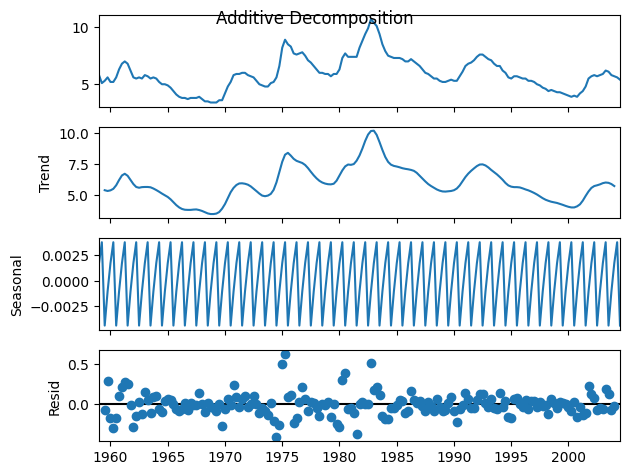

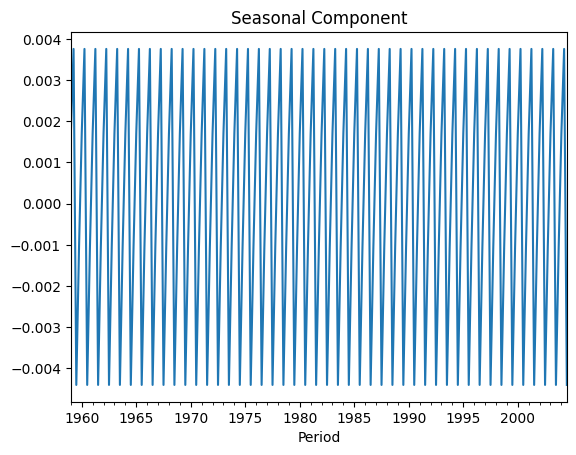

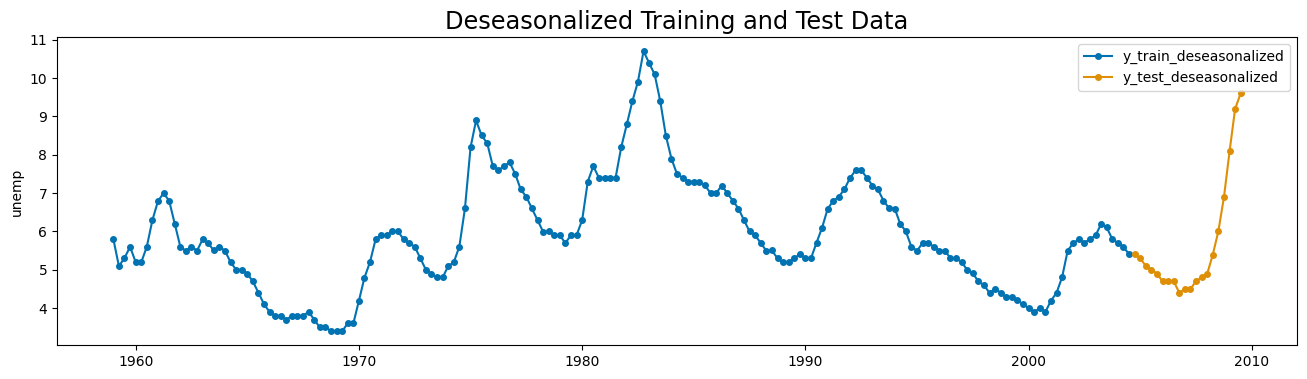

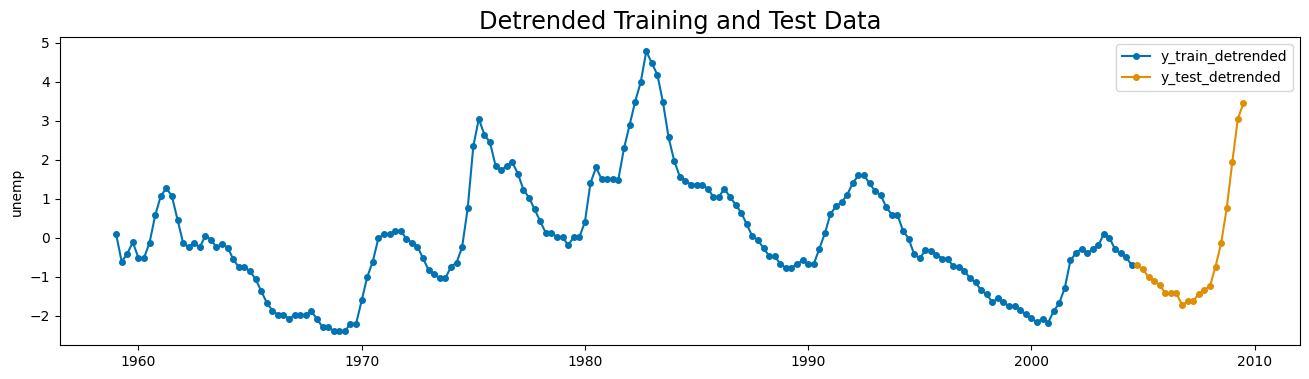


Stationarity Check After Deseasonalizing and Detrending:
ADF Statistic: -2.4017829353251496
p-value: 0.14123382059687978
Critical Values:
   1%, -3.4687256239864017
Critical Values:
   5%, -2.8783961376954363
Critical Values:
   10%, -2.57575634100705

The time series is not stationary.

Applying Differencing to Achieve Stationarity:


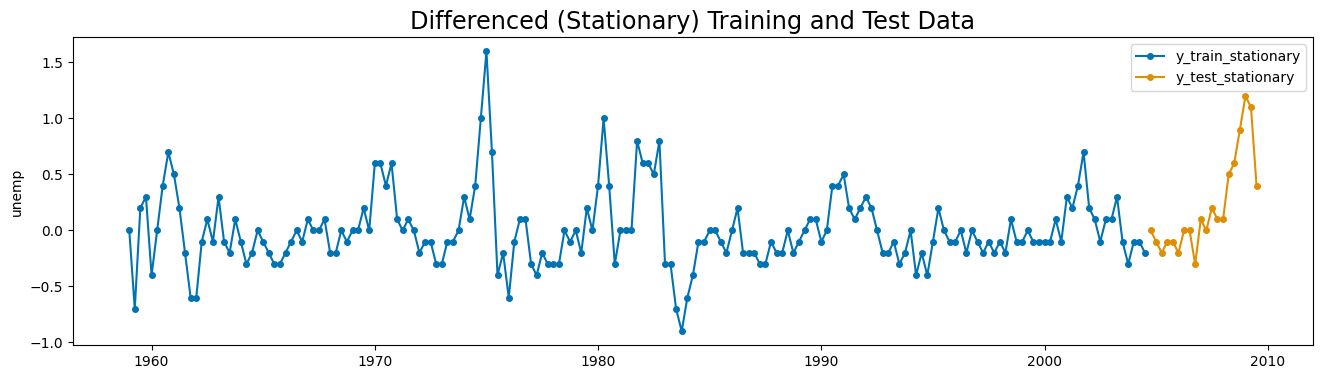


Stationarity Check After Differencing:
ADF Statistic: -4.920811025730545
p-value: 3.1763350159869606e-05
Critical Values:
   1%, -3.4691814633722453
Critical Values:
   5%, -2.878595143532943
Critical Values:
   10%, -2.5758625549741803

The time series is stationary.


In [ ]:
# Ensure the index has a frequency set
y_train = y_train.asfreq('Q')
y_test = y_test.asfreq('Q')

# Check stationarity before transformation
print("Stationarity Check Before Transformation:")
check_stationarity(y_train)

# Compare models and decide which one to use
recommended_model, decomposition = compare_models(y_train, period=4)

# Decompose and plot the recommended model
decompose_and_plot(y_train, model=recommended_model, period=4, title=f"{recommended_model.capitalize()} Decomposition")

# Extract and plot the seasonal component to verify the transformation
seasonal_component = decomposition.seasonal
seasonal_component.plot()
plt.title("Seasonal Component")
plt.show()

# Apply deseasonalizer
y_train_deseasonalized, y_test_deseasonalized = apply_deseasonalizer(y_train, y_test, model=recommended_model, sp=4)

# Plot the deseasonalized training and test data
fig, ax = plot_series(
    y_train_deseasonalized, y_test_deseasonalized,
    labels=["y_train_deseasonalized", "y_test_deseasonalized"],
    title="Deseasonalized Training and Test Data"
)
plt.show()

# Apply detrender
y_train_detrended, y_test_detrended = apply_detrender(y_train, y_test, model=recommended_model)

# Plot the detrended training and test data
fig, ax = plot_series(
    y_train_detrended, y_test_detrended,
    labels=["y_train_detrended", "y_test_detrended"],
    title="Detrended Training and Test Data"
)
plt.show()

# Check stationarity after transformation
print("\nStationarity Check After Deseasonalizing and Detrending:")
if not check_stationarity(y_train_detrended):
    print("\nApplying Differencing to Achieve Stationarity:")
    y_train_stationary, y_test_stationary = apply_differencer(y_train_detrended, y_test_detrended, lags=[1])

    # Plot the differenced training and test data
    fig, ax = plot_series(
        y_train_stationary, y_test_stationary,
        labels=["y_train_stationary", "y_test_stationary"],
        title="Differenced (Stationary) Training and Test Data"
    )
    plt.show()

    # Check stationarity after differencing
    print("\nStationarity Check After Differencing:")
    check_stationarity(y_train_stationary)
else:
    y_train_stationary = y_train_detrended
    y_test_stationary = y_test_detrended

# Create Pipeline

In [9]:
# Define the forecast horizon (predict the next 20 periods)
fh = ForecastingHorizon(y_test.index, is_relative=False)
print(f"The forecast horizon is {len(fh)} periods.")
print(f"\nAbsolute forecast horizon:\n{fh}")

fh = fh.to_relative(cutoff=y_train.index[-1])
print(f"\nRelative forecast horizon:\n{fh}")

The forecast horizon is 20 periods.

Absolute forecast horizon:
ForecastingHorizon(['2004Q4', '2005Q1', '2005Q2', '2005Q3', '2005Q4', '2006Q1',
             '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2', '2007Q3',
             '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4', '2009Q1',
             '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', name='Period', is_relative=False)

Relative forecast horizon:
ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', is_relative=True)


In [10]:
# Define the transformations
deseasonalizer = Deseasonalizer(model='additive', sp=4)  # For quarterly data
detrender = Detrender(model='additive')
differencer = Differencer(lags=[1, 4])
scaler = TabularToSeriesAdaptor(MinMaxScaler())

In [11]:
# Define the regressor
regressor = RandomForestRegressor()

# Define the arguments
strategy = "recursive"
window_length = 2 * len(fh)
pooling = "global"

# Print the arguments
print("Strategy:", strategy)
print("Window Length:", window_length)
print("Pooling:", pooling)

# Create forecaster via reduction
forecaster_from_reduction = make_reduction(
    estimator=regressor,
    strategy=strategy,
    window_length=window_length,
    pooling=pooling
)

# Add probabilistic capabilities
forecaster = NaiveVariance(forecaster_from_reduction)

Strategy: recursive
Window Length: 40
Pooling: global


In [12]:
# Define the endogenous pipeline
pipeline_endog = TransformedTargetForecaster(steps=[
    ("deseasonalizer", deseasonalizer),
    ("detrender", detrender),
    ("differencer", differencer),
    ("scaler", scaler),
    ("forecaster", forecaster)
])

# Define the nested pipeline (endogenous and exogenous)
pipeline = ForecastingPipeline(steps=[
    ("deseasonalizer", deseasonalizer),
    ("detrender", detrender),
    ("differencer", differencer),
    ("scaler", scaler),
    ("forecaster", pipeline_endog)
])

# Fit the pipeline
pipeline.fit(y=y_train, X=X_train)

ForecastingPipeline(steps=[('deseasonalizer', Deseasonalizer(sp=4)),
                           ('detrender', Detrender()),
                           ('differencer', Differencer(lags=[1, 4])),
                           ('scaler',
                            TabularToSeriesAdaptor(transformer=MinMaxScaler())),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('deseasonalizer',
                                                                Deseasonalizer(sp=4)),
                                                               ('detrender',
                                                                Detrender()),
                                                               ('differencer',
                                                                Differencer(lags=[1,
                                                                                  4])),
                                                               ('scaler',
                                                                TabularToSeriesAdaptor(transformer=MinMaxScaler())),
                                                               ('forecaster',
                                                                NaiveVariance(forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                                                                              pooling='global',
                                                                                                                              window_length=40)))]))])

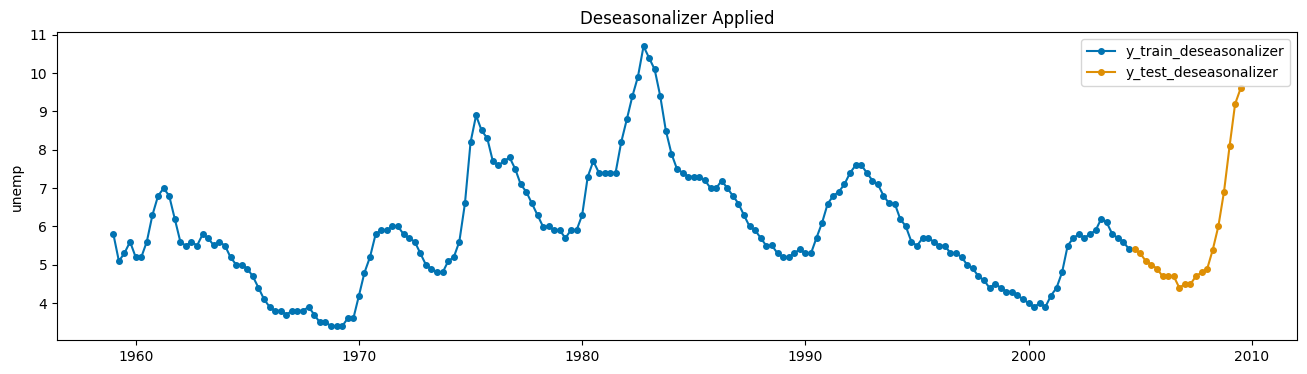

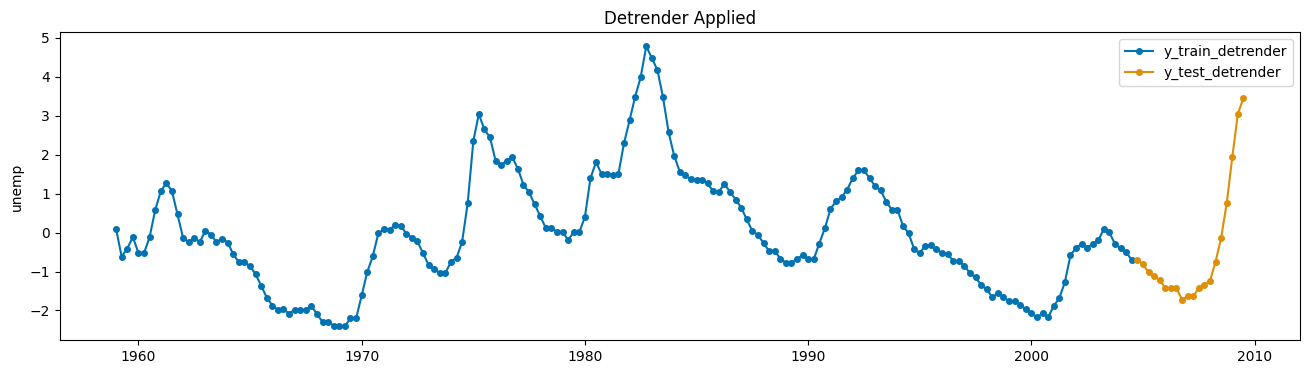

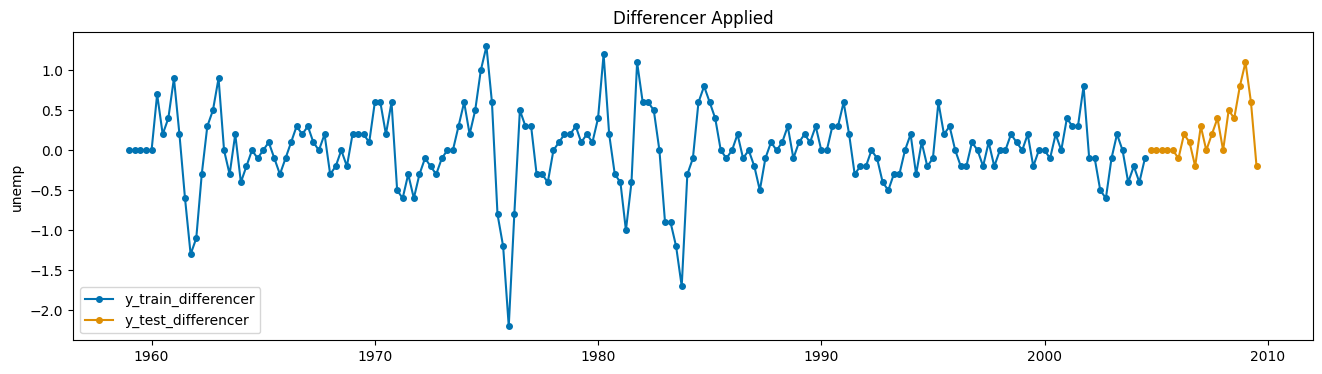

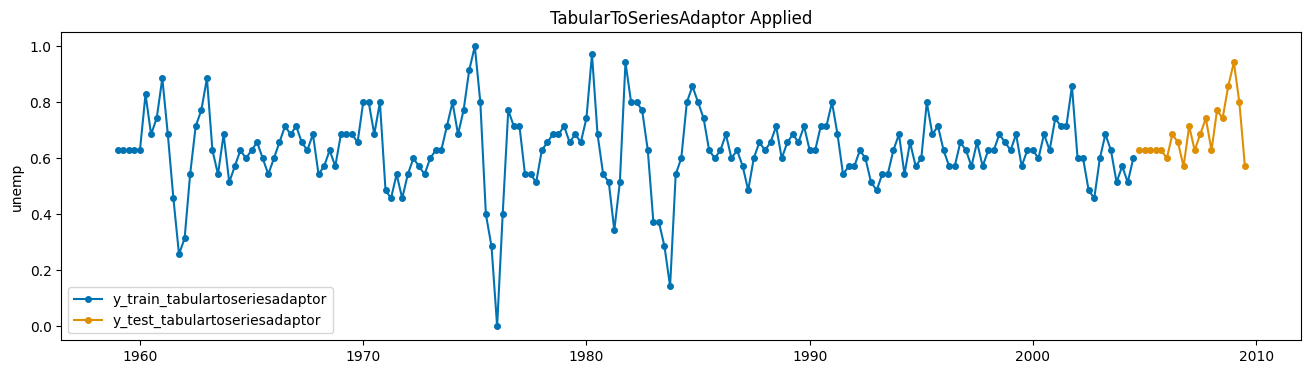

In [ ]:
# Function to plot the transformation flow
def apply_transformations_and_plot(y_train, y_test, transformers):
    """
    Apply a sequence of transformations to the training and test time series data and plot the results.

    Parameters:
    y_train (pd.Series): The training time series data.
    y_test (pd.Series): The test time series data.
    transformers (list): A list of transformer objects that implement the fit_transform and transform methods.

    Returns:
    None
    """
    y_train_transformed = y_train
    y_test_transformed = y_test

    for transformer in transformers:
        y_train_transformed = transformer.fit_transform(y_train_transformed)
        y_test_transformed = transformer.transform(y_test_transformed)
        fig, ax = plot_series(y_train_transformed, y_test_transformed, labels=[f"y_train_{type(transformer).__name__.lower()}", f"y_test_{type(transformer).__name__.lower()}"])
        ax.set_title(f"{type(transformer).__name__} Applied")
        plt.show()

# List of transformers
transformers = [deseasonalizer, detrender, differencer, scaler]

# Apply transformations and plot the results
apply_transformations_and_plot(y_train, y_test, transformers)

# Forecasting

In [ ]:
# Get predictions
y_pred = pipeline.predict(fh=fh, X=X_test)

# Get interval predictions
coverage = 0.9
y_pred_int = pipeline.predict_interval(fh=fh, X=X_test, coverage=coverage)

# Get quantile predictions
alpha = [0.1, 0.25, 0.5, 0.75, 0.9]
y_pred_quant = pipeline.predict_quantiles(fh=fh, X=X_test, alpha=alpha)

# Get distribution predictions
y_pred_dist = pipeline.predict_proba(fh=fh, X=X_test)

# Plotting

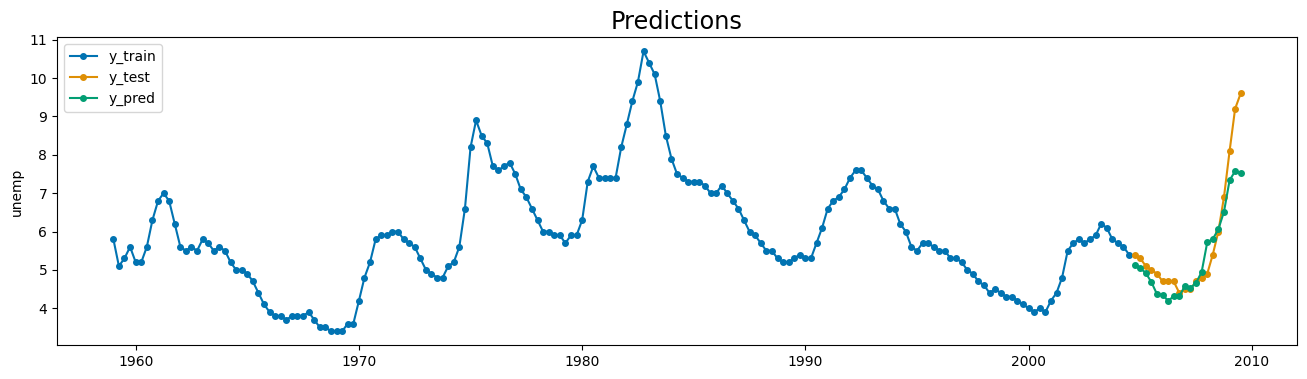

In [ ]:
# Plot the predictions
fig, ax = plot_series(
    y_train, y_test, y_pred,
    labels=["y_train", "y_test", "y_pred"],
    title="Predictions"
)

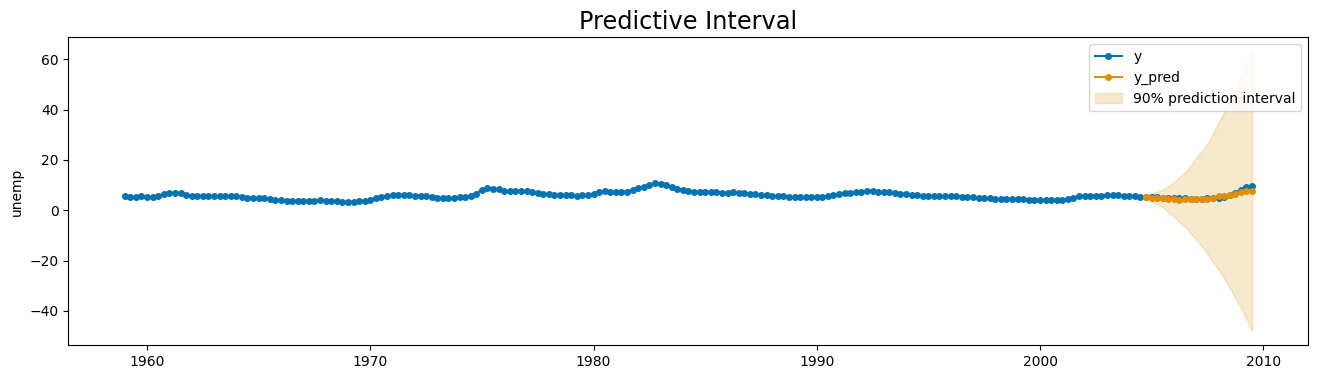

In [ ]:
# Plot predictive interval
fig, ax = plot_series(
    y, y_pred,
    labels=["y", "y_pred"],
    pred_interval=y_pred_int,
    title="Predictive Interval"
)
ax.legend();

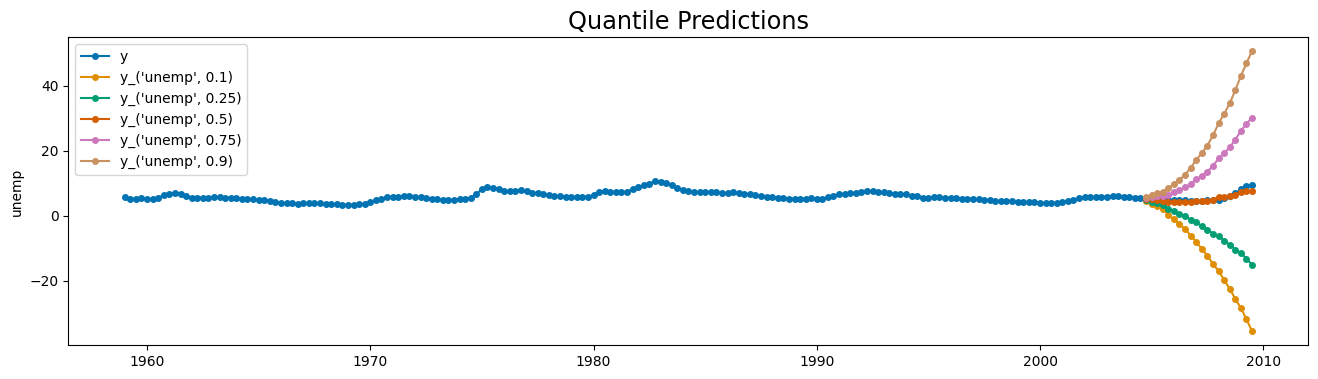

In [ ]:
# Extract quantile levels from y_pred_quant DataFrame
quant_levels = [f"y_{q}" for q in y_pred_quant.columns]

# Combine the label 'y' with the quantile levels
labels = ["y"] + quant_levels

# Convert y_pred_quant columns to a list for plotting
quant_columns = [y_pred_quant[col] for col in y_pred_quant.columns]

# Plot quantile predictions
fig, ax = plot_series(
    y, *quant_columns,
    labels=labels,
    title="Quantile Predictions"
)

# Metrics

In [ ]:
# Initialize metrics
mse = MeanSquaredError()
rmse = MeanSquaredError(square_root=True)
mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError()
smape = MeanAbsolutePercentageError(symmetric=True)
mase = MeanAbsoluteScaledError()
pb_loss = PinballLoss()
emp_cov = EmpiricalCoverage()
au_cal = AUCalibration()
log_loss = LogLoss()
crps = CRPS()

# Compute metrics
metrics = {
    'mse': mse.evaluate(y_test, y_pred),
    'rmse': rmse.evaluate(y_test, y_pred),
    'mae': mae.evaluate(y_test, y_pred),
    'mape': mape.evaluate(y_test, y_pred),
    'smape': smape.evaluate(y_test, y_pred),
    'mase': mase.evaluate(y_test, y_pred, y_train=y_train),
    'pb_loss': pb_loss.evaluate(y_test, y_pred_quant),
    'emp_cov': emp_cov.evaluate(y_test, y_pred_int),
    'au_cal': au_cal.evaluate(y_test, y_pred_dist).iloc[0, 0],
    'log_loss': log_loss.evaluate(y_test, y_pred_dist).iloc[0, 0],
    'crps': crps.evaluate(y_test, y_pred_dist).iloc[0, 0]
}

# Create metrics DataFrame
metrics_df = pd.DataFrame([metrics], index=['Value'])
metrics_df = metrics_df.T
print("Metrics DataFrame:")
metrics_df

Metrics DataFrame:


,Value
mse,0.480229
rmse,0.692985
mae,0.464600
mape,0.072225
smape,0.075093
mase,2.022900
pb_loss,1.591279
emp_cov,1.000000
au_cal,0.475000
log_loss,2.993299


# Backtesting

In [ ]:
# Define the forecast horizon
fh_backtest = ForecastingHorizon(np.arange(1, 21))
print(f"The forecast horizon is {len(fh_backtest)} periods.")
print(f"\nForecast horizon:\n{fh_backtest}")
initial_window = 160

The forecast horizon is 20 periods.

Forecast horizon:
ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', is_relative=True)


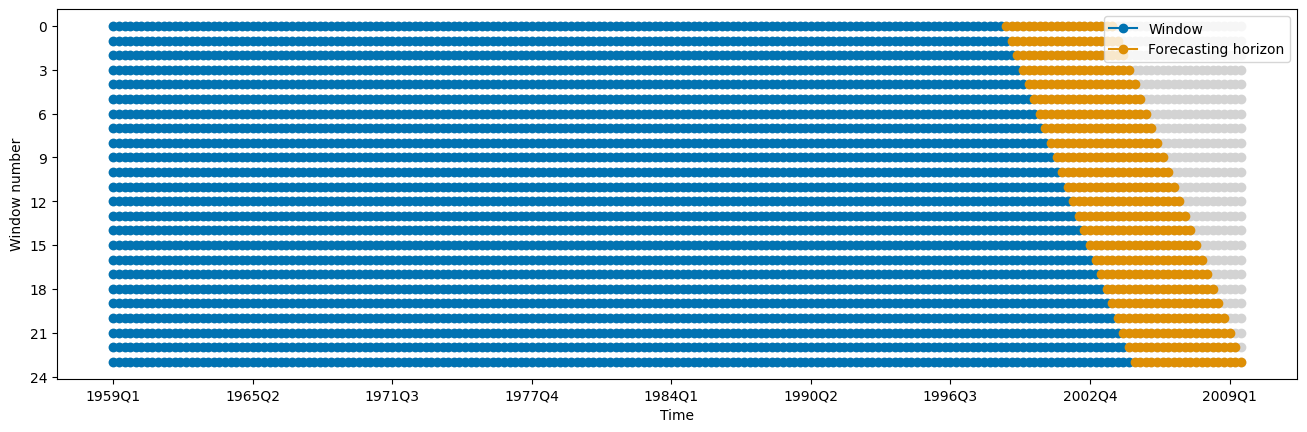

In [ ]:
# Define cross-validation splitter
cv = ExpandingWindowSplitter(fh=fh_backtest, initial_window=initial_window, step_length=1)
plot_windows(cv=cv, y=y);

In [ ]:
# Define list of metrics
metrics = [
    mse,
    rmse,
    mae,
    mape,
    smape,
    mase,
    pb_loss,
    emp_cov,
    au_cal,
    log_loss,
    crps
]

# Evaluate forecaster using cross-validation
results_df = evaluate(
    forecaster=pipeline,
    y=y,
    X=X,
    cv=cv,
    scoring=metrics
)

# Print results
print("\nEvaluation Results:")
results_df


Evaluation Results:


,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,test_MeanAbsoluteScaledError,test_PinballLoss,test_EmpiricalCoverage,test_AUCalibration,test_LogLoss,test_CRPS,fit_time,pred_time,pred_quantiles_time,pred_interval_time,pred_proba_time,len_train_window,cutoff
0,1.168999,0.99170,0.170754,4.171437,1.147154,1.0,0.245,3.055959,3.297186,723.280096,2.177848,2.265380,2.199253,4.319698,160,1998Q4
1,0.749683,0.63165,0.113552,2.666596,1.144827,1.0,0.275,3.052219,3.272104,733.102211,2.248252,2.200519,2.214165,4.280712,161,1999Q1
2,0.964265,0.84450,0.150356,3.587454,1.132628,1.0,0.085,3.050865,3.261943,744.689014,2.187215,2.234980,2.237841,4.499490,162,1999Q2
3,0.799155,0.62900,0.111301,2.681526,1.128391,1.0,0.220,3.038359,3.238759,755.603984,2.182356,2.214747,2.201238,4.391956,163,1999Q3
4,0.746689,0.61050,0.122005,2.611850,1.122752,1.0,0.205,3.032911,3.208058,771.195398,2.151233,2.183903,2.272953,4.280209,164,1999Q4
5,1.830881,1.41080,0.326269,6.056838,1.130561,1.0,0.285,3.063654,3.282497,778.606498,2.217230,2.253505,2.454296,4.360762,165,2000Q1
6,0.806574,0.75755,0.132989,3.263597,1.117331,1.0,0.125,3.049278,3.228217,792.091626,2.182904,2.267638,2.215495,4.337027,166,2000Q2
7,0.598195,0.50495,0.094603,2.182857,1.114333,1.0,0.070,3.084410,3.228555,805.518197,2.178110,2.219935,2.362434,4.269308,167,2000Q3
8,1.102705,0.95570,0.199918,4.145504,1.114607,1.0,0.295,3.033375,3.200400,812.599303,2.171666,2.213865,2.213746,4.593826,168,2000Q4
9,1.620519,1.44220,0.325854,6.244577,1.105056,1.0,0.405,3.028299,3.211630,828.490686,2.173491,2.216251,2.213921,4.319776,169,2001Q1


# Tuning

In [ ]:
# Define the forecast horizon
n_periods = 16
fh_tuner = ForecastingHorizon(np.arange(1, n_periods + 1))
print(f"The forecast horizon is {len(fh_tuner)} periods.")
print(f"\nForecast horizon:\n{fh_tuner}")

The forecast horizon is 16 periods.

Forecast horizon:
ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64', is_relative=True)


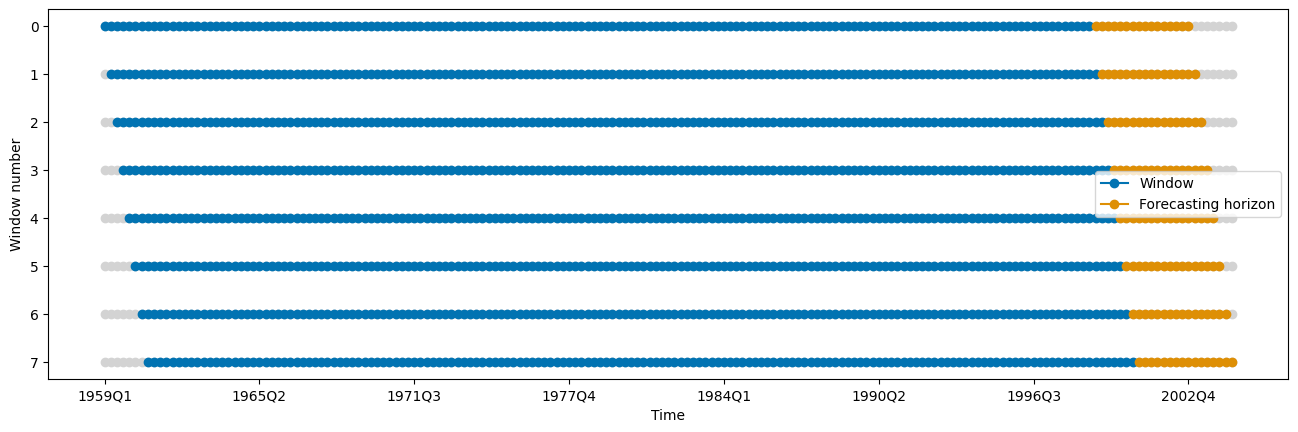

In [ ]:
# Define cross-validation splitter
window_length_cv = 4 * window_length
cv = SlidingWindowSplitter(fh=fh_tuner, window_length=window_length_cv, step_length=1)
plot_windows(cv=cv, y=y_train);

In [ ]:
# Define parameter distributions
param_grid = {
    "forecaster__forecaster__forecaster__estimator__n_estimators": IntDistribution(50, 200),
    "forecaster__forecaster__forecaster__estimator__min_samples_split": IntDistribution(2, 10)
}

In [ ]:
# Run the Bayesian cross-validation search
oscv = ForecastingOptunaSearchCV(
    forecaster=pipeline,
    param_grid=param_grid,
    cv=cv,
    n_evals=5,
    error_score="raise",
    refit=True
)
oscv.fit(y=y_train, X=X_train, fh=fh_tuner)

[I 2024-08-10 09:16:54,975] A new study created in memory with name: no-name-ec808e41-bbfc-4e6c-bb8f-b2970f78bb1c


ForecastingOptunaSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64', is_relative=True),
                                                   window_length=160),
                          error_score='raise',
                          forecaster=ForecastingPipeline(steps=[('deseasonalizer',
                                                                 Deseasonalizer(sp=4)),
                                                                ('detrender',
                                                                 Detrender()),
                                                                ('differencer',
                                                                 Differencer(lags=[1,
                                                                                   4])),
                                                                ('scaler',
                                                                 TabularToSe...
                                                                                                     NaiveVariance(forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                                                                                                                                                   pooling='global',
                                                                                                                                                                   window_length=40)))]))]),
                          n_evals=5,
                          param_grid={'forecaster__forecaster__forecaster__estimator__min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                      'forecaster__forecaster__forecaster__estimator__n_estimators': IntDistribution(high=200, log=False, low=50, step=1)})

In [ ]:
# Print best parameters
print("Best Parameters:")
print(pd.Series(oscv.best_params_))

# Print best score
print("\nBest Score:")
print(oscv.best_score_)

Best Parameters:
forecaster__forecaster__forecaster__estimator__n_estimators         191
forecaster__forecaster__forecaster__estimator__min_samples_split      3
dtype: int64

Best Score:
0.12291826210777776


In [ ]:
# Function to display cross-validation results
def display_cv_results(cv_object):
    """
    Display cross-validation results from a scikit-learn GridSearchCV or RandomizedSearchCV object.

    Parameters:
    cv_object (object): A fitted scikit-learn GridSearchCV or RandomizedSearchCV object.

    Returns:
    None
    """
    # Ensure cv_results_ is a DataFrame
    cv_results_df = pd.DataFrame(cv_object.cv_results_)

    # Function to extract the last words before the last double underscore
    def extract_last_words(column_name):
        """
        Extract the last part of a column name after the last double underscore.

        Parameters:
        column_name (str): The original column name.

        Returns:
        str: The modified column name.
        """
        if '__' in column_name:
            return column_name.split('__')[-1]
        else:
            return column_name

    # Rename the columns dynamically
    cv_results_df.columns = [extract_last_words(col) for col in cv_results_df.columns]

    # Print cross-validation results
    print("Cross-Validation Results:")
    display(cv_results_df)

# Use the function
display_cv_results(oscv)

Cross-Validation Results:


,number,value,datetime_start,datetime_complete,duration,min_samples_split,n_estimators,state,params,rank_test_MeanAbsolutePercentageError
0,0,0.131951,2024-08-10 09:16:54.977986,2024-08-10 11:06:05.760676,0 days 01:49:10.782690,4,195,COMPLETE,{'forecaster__forecaster__forecaster__estimato...,3.0
1,1,0.122918,2024-08-10 11:06:05.760874,2024-08-10 12:59:13.448496,0 days 01:53:07.687622,3,191,COMPLETE,{'forecaster__forecaster__forecaster__estimato...,1.0
2,2,0.138127,2024-08-10 12:59:13.448673,2024-08-10 14:50:29.604137,0 days 01:51:16.155464,3,142,COMPLETE,{'forecaster__forecaster__forecaster__estimato...,4.0
3,3,0.129906,2024-08-10 14:50:29.604317,2024-08-10 16:40:16.026047,0 days 01:49:46.421730,2,132,COMPLETE,{'forecaster__forecaster__forecaster__estimato...,2.0
4,4,0.153412,2024-08-10 16:40:16.026227,2024-08-10 18:24:46.851083,0 days 01:44:30.824856,3,115,COMPLETE,{'forecaster__forecaster__forecaster__estimato...,5.0


In [ ]:
# Define fitted forecaster with best params
best_forecaster = oscv.best_forecaster_
best_forecaster.fit(y=y_train, X=X_train)

ForecastingPipeline(steps=[('deseasonalizer', Deseasonalizer(sp=4)),
                           ('detrender', Detrender()),
                           ('differencer', Differencer(lags=[1, 4])),
                           ('scaler',
                            TabularToSeriesAdaptor(transformer=MinMaxScaler())),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('deseasonalizer',
                                                                Deseasonalizer(sp=4)),
                                                               ('detrender',
                                                                Detrender()),
                                                               ('differencer',
                                                                Differencer(lags=[1,
                                                                                  4])),
                                                               ('scaler',
                                                                TabularToSeriesAdaptor(transformer=MinMaxScaler())),
                                                               ('forecaster',
                                                                NaiveVariance(forecaster=RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(min_samples_split=3, n_estimators=191),
                                                                                                                              pooling='global',
                                                                                                                              window_length=40)))]))])

In [ ]:
# Function to get predictions
def get_predictions(pipeline, fh, X_test, coverage=0.9, alpha=[0.1, 0.25, 0.5, 0.75, 0.9]):
    """
    Get various types of predictions from a forecasting pipeline.

    Parameters:
    pipeline (object): A fitted forecasting pipeline object.
    fh (ForecastingHorizon): The forecasting horizon.
    X_test (pd.DataFrame or np.ndarray): Exogenous variables to be used for prediction.
    coverage (float): The coverage for interval predictions. Default is 0.9.
    alpha (list): The quantiles for quantile predictions. Default is [0.1, 0.25, 0.5, 0.75, 0.9].

    Returns:
    y_pred (pd.Series or np.ndarray): Point predictions.
    y_pred_int (pd.DataFrame): Interval predictions.
    y_pred_quant (pd.DataFrame): Quantile predictions.
    y_pred_dist (pd.DataFrame or np.ndarray): Distribution predictions.
    """
    # Get point predictions
    y_pred = pipeline.predict(fh=fh, X=X_test)

    # Get interval predictions
    y_pred_int = pipeline.predict_interval(fh=fh, X=X_test, coverage=coverage)

    # Get quantile predictions
    y_pred_quant = pipeline.predict_quantiles(fh=fh, X=X_test, alpha=alpha)

    # Get distribution predictions
    y_pred_dist = pipeline.predict_proba(fh=fh, X=X_test)

    return y_pred, y_pred_int, y_pred_quant, y_pred_dist

# Use the function
y_pred, y_pred_int, y_pred_quant, y_pred_dist = get_predictions(best_forecaster, fh, X_test)

In [ ]:
# Function to get metrics DataFrame
def compute_metrics(y_test, y_pred, y_pred_quant=None, y_pred_int=None, y_pred_dist=None, y_train=None):
    """
    Compute various evaluation metrics for time series predictions.

    Parameters:
    y_test (pd.Series or np.ndarray): The true values of the test set.
    y_pred (pd.Series or np.ndarray): The point predictions.
    y_pred_quant (pd.DataFrame, optional): The quantile predictions. Default is None.
    y_pred_int (pd.DataFrame, optional): The interval predictions. Default is None.
    y_pred_dist (pd.DataFrame or np.ndarray, optional): The distribution predictions. Default is None.
    y_train (pd.Series or np.ndarray, optional): The true values of the training set for computing MASE. Default is None.

    Returns:
    metrics_df (pd.DataFrame): A DataFrame containing the computed metrics.
    """
    # Initialize metrics
    mse = MeanSquaredError()
    rmse = MeanSquaredError(square_root=True)
    mae = MeanAbsoluteError()
    mape = MeanAbsolutePercentageError()
    smape = MeanAbsolutePercentageError(symmetric=True)
    mase = MeanAbsoluteScaledError()
    pb_loss = PinballLoss()
    emp_cov = EmpiricalCoverage()
    au_cal = AUCalibration()
    log_loss = LogLoss()
    crps = CRPS()

    # Compute metrics
    metrics = {
        'mse': mse.evaluate(y_test, y_pred),
        'rmse': rmse.evaluate(y_test, y_pred),
        'mae': mae.evaluate(y_test, y_pred),
        'mape': mape.evaluate(y_test, y_pred),
        'smape': smape.evaluate(y_test, y_pred),
    }

    if y_train is not None:
        metrics['mase'] = mase.evaluate(y_test, y_pred, y_train=y_train)

    if y_pred_quant is not None:
        metrics['pb_loss'] = pb_loss.evaluate(y_test, y_pred_quant)

    if y_pred_int is not None:
        metrics['emp_cov'] = emp_cov.evaluate(y_test, y_pred_int)

    if y_pred_dist is not None:
        metrics['au_cal'] = au_cal.evaluate(y_test, y_pred_dist).iloc[0, 0]
        metrics['log_loss'] = log_loss.evaluate(y_test, y_pred_dist).iloc[0, 0]
        metrics['crps'] = crps.evaluate(y_test, y_pred_dist).iloc[0, 0]

    # Create metrics DataFrame
    metrics_df = pd.DataFrame([metrics], index=['Value'])
    metrics_df = metrics_df.T

    return metrics_df

# Use the function
metrics_df = compute_metrics(y_test, y_pred, y_pred_quant, y_pred_int, y_pred_dist, y_train)
print("Metrics DataFrame:")
metrics_df

Metrics DataFrame:


,Value
mse,0.917538
rmse,0.957882
mae,0.574993
mape,0.082146
smape,0.088966
mase,2.503559
pb_loss,1.606424
emp_cov,1.000000
au_cal,0.450000
log_loss,2.991954


# Custom Forecasters

## Sklearn

In [13]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveVariance

# Function to create forecasters
def create_forecasters(models, strategy="recursive", window_length=10, pooling="global"):
    """
    Create a list of forecasters using the given models.

    Parameters:
    models (list of tuples): A list of tuples where each tuple contains a model name (str) and a model instance.
    strategy (str): The reduction strategy to use. Default is "recursive".
    window_length (int): The window length to use for the reduction. Default is 10.
    pooling (str): The pooling method to use. Default is "global".

    Returns:
    forecasters (list): A list of forecaster objects with probabilistic capabilities.
    """
    forecasters = []

    for model_name, model in models:
        # Create forecaster via reduction
        forecaster_from_reduction = make_reduction(
            estimator=model,
            strategy=strategy,
            window_length=window_length,
            pooling=pooling
        )

        # Add probabilistic capabilities
        forecaster = NaiveVariance(forecaster_from_reduction)

        forecasters.append(forecaster)

    return forecasters

# Define the models
models = [
    ("sv", SVR()),
    ("rf", RandomForestRegressor()),
    ("hist_gb", HistGradientBoostingRegressor()),
    ("lgbm", LGBMRegressor(verbose=-1)),
    ("xgb", XGBRegressor())
]

# Create forecasters
sv_forecaster, rf_forecaster, hist_gb_forecaster, lgbm_forecaster, xgb_forecaster = create_forecasters(models=models, window_length=window_length)

## Sktime

In [14]:
from sktime.regression.deep_learning.cnn import CNNRegressor
from sktime.regression.deep_learning.lstmfcn import LSTMFCNRegressor
from sktime.regression.deep_learning.resnet import ResNetRegressor
from sktime.regression.kernel_based import RocketRegressor

# Define the models
models = [
    ("cnn", CNNRegressor()),
    ("lstm_fcn", LSTMFCNRegressor()),
    ("resnet", ResNetRegressor()),
    ("rocket", RocketRegressor())
]

# Create forecasters
cnn_forecaster, lstm_fcn_forecaster, resnet_forecaster, rocket_forecaster = create_forecasters(models=models, window_length=window_length)

# Model Selection

In [15]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.trend import ProphetPiecewiseLinearTrendForecaster
from sktime.forecasting.theta import ThetaForecaster

# Create other forecasters
naive_forecaster = NaiveForecaster(strategy="drift")
es_forecaster = ExponentialSmoothing(trend="add", seasonal="add", sp=4)
arima_forecaster = AutoARIMA(sp=4, suppress_warnings=True)
prophet_forecaster = ProphetPiecewiseLinearTrendForecaster()
theta_forecaster = ThetaForecaster(sp=1)

In [16]:
# Define the forecasters for model selection
forecaster_multiplex = MultiplexForecaster(forecasters=[
    ("sv", sv_forecaster),
    ("rf", rf_forecaster),
    ("hist_gb", hist_gb_forecaster),
    ("lgbm", lgbm_forecaster),
    ("xgb", xgb_forecaster),
    ("cnn", cnn_forecaster),
    ("lstm_fcn", lstm_fcn_forecaster),
    ("resnet", resnet_forecaster),
    ("rocket", rocket_forecaster),
    ("naive", naive_forecaster),
    ("es", es_forecaster),
    ("arima", arima_forecaster),
    ("prophet", prophet_forecaster),
    ("theta", theta_forecaster)
])

In [17]:
# Define the endogenous pipeline
pipeline_endog_multi = TransformedTargetForecaster(steps=[
    ("deseasonalizer", deseasonalizer),
    ("detrender", detrender),
    ("differencer", differencer),
    ("scaler", scaler),
    ("forecaster", forecaster_multiplex)
])

# Define the nested pipeline (endogenous and exogenous)
pipeline_multi = ForecastingPipeline(steps=[
    ("deseasonalizer", deseasonalizer),
    ("detrender", detrender),
    ("differencer", differencer),
    ("scaler", scaler),
    ("forecaster", pipeline_endog_multi)
])

In [18]:
# Create model param grid
param_grid_models = {"forecaster__forecaster__selected_forecaster": [
    "sv",
    "rf",
    "hist_gb",
    "lgbm",
    "xgb",
    "cnn",
    "lstm_fcn",
    "resnet",
    "rocket",
    "naive",
    "es",
    "arima",
    "prophet",
    "theta"
]}

In [57]:
# Define the forecast horizon
n_periods = 20
fh_selection = ForecastingHorizon(np.arange(1, n_periods + 1))
print(f"The forecast horizon is {len(fh_selection)} periods.")
print(f"\nForecast horizon:\n{fh_selection}")

The forecast horizon is 20 periods.

Forecast horizon:
ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', is_relative=True)


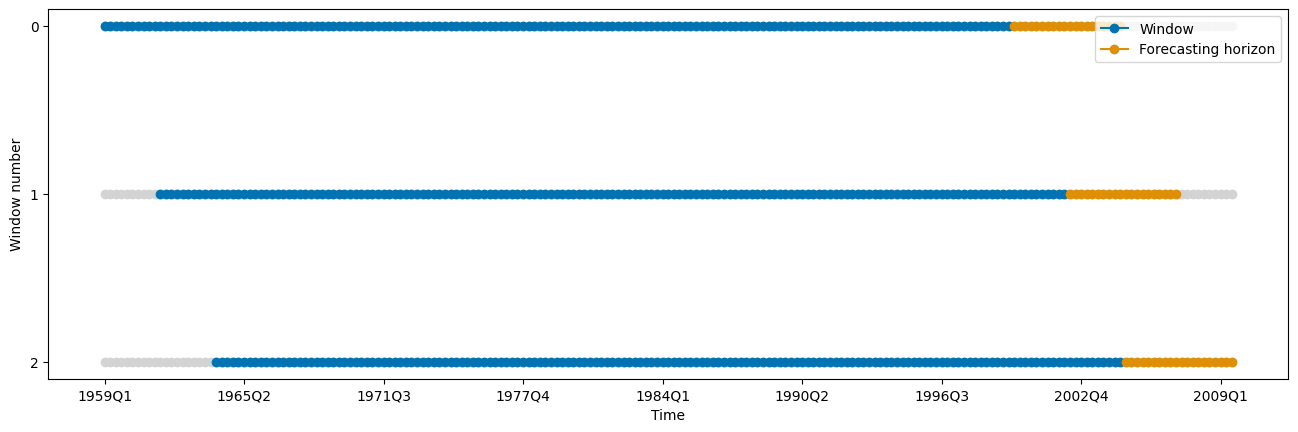

In [58]:
# Define cross-validation splitter
window_length_cv = 4 * window_length + 3
cv = SlidingWindowSplitter(fh=fh_selection, window_length=window_length_cv, step_length=10)
plot_windows(cv=cv, y=y);

In [59]:
# Run the search
gscv = ForecastingGridSearchCV(
    forecaster=pipeline_multi,
    param_grid=param_grid_models,
    cv=cv,
    error_score=np.nan,
    backend=None,
    verbose=1
)
gscv.fit(y=y, X=X, fh=fh_selection)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


/usr/local/lib/python3.10/dist-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ForecastingPipeline failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff NaT, and len(y_train)=163.
                The score will be set to nan.
                Failed forecaster with parameters: ForecastingPipeline(steps=[('deseasonalizer', Deseasonalizer(sp=4)),
                           ('detrender', Detrender()),
                           ('differencer', Differencer(lags=[1, 4])),
                           ('scaler',
                            TabularToSeriesAdaptor(transformer=MinMaxScaler())),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('deseasonalizer',
                                                             

ForecastingGridSearchCV(backend=None,
                        cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', is_relative=True),
                                                 step_length=10,
                                                 window_length=163),
                        forecaster=ForecastingPipeline(steps=[('deseasonalizer',
                                                               Deseasonalizer(sp=4)),
                                                              ('detrender',
                                                               Detrender()),
                                                              ('differencer',
                                                               Differencer(lags=[1,
                                                                                 4])),
                                                              ('s...
                                                                                                                                     ExponentialSmoothing(seasonal='add',
                                                                                                                                                          sp=4,
                                                                                                                                                          trend='add')),
                                                                                                                                    ('arima',
                                                                                                                                     AutoARIMA(sp=4,
                                                                                                                                               suppress_warnings=True)),
                                                                                                                                    ('prophet',
                                                                                                                                     ProphetPiecewiseLinearTrendForecaster()),
                                                                                                                                    ('theta',
                                                                                                                                     ThetaForecaster())]))]))]),
                        param_grid={'forecaster__forecaster__selected_forecaster': ['sv',
                                                                                    'rf',
                                                                                    'hist_gb',
                                                                                    'lgbm',
                                                                                    'xgb',
                                                                                    'cnn',
                                                                                    'lstm_fcn',
                                                                                    'resnet',
                                                                                    'rocket',
                                                                                    'naive',
                                                                                    'es',
                                                                                    'arima',
                                                                                    'prophet',
                                                                                    'theta']},
                        verbose=1)

In [60]:
# Print best parameters
print("Best Parameters:")
print(pd.Series(gscv.best_params_))

# Print best score
print("\nBest Score:")
print(gscv.best_score_)

Best Parameters:
forecaster__forecaster__selected_forecaster    arima
dtype: object

Best Score:
0.11868738459517635


In [64]:
# Print CV results
display_cv_results(gscv)

Cross-Validation Results:


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.288419,488.253669,1.450968,{'forecaster__forecaster__selected_forecaster'...,6.0
1,0.202704,533.299249,1.556844,{'forecaster__forecaster__selected_forecaster'...,5.0
2,0.160600,503.562808,1.609179,{'forecaster__forecaster__selected_forecaster'...,2.0
3,0.188583,489.521169,1.467166,{'forecaster__forecaster__selected_forecaster'...,3.0
4,0.191202,972.893671,1.702071,{'forecaster__forecaster__selected_forecaster'...,4.0
5,NaN,NaN,NaN,{'forecaster__forecaster__selected_forecaster'...,NaN
6,NaN,NaN,NaN,{'forecaster__forecaster__selected_forecaster'...,NaN
7,NaN,NaN,NaN,{'forecaster__forecaster__selected_forecaster'...,NaN
8,NaN,NaN,NaN,{'forecaster__forecaster__selected_forecaster'...,NaN
9,0.752833,0.532099,0.084833,{'forecaster__forecaster__selected_forecaster'...,9.0


In [66]:
# Convert CV results to DataFrame
cv_df = pd.DataFrame(gscv.cv_results_)

# Extract and clean the 'params' column
def clean_params(params):
    return {key.split('__')[-1]: value for key, value in params.items()}

cv_df['cleaned_params'] = cv_df['params'].apply(clean_params)

# Print the relevant columns
display(cv_df[[
    'mean_test_MeanAbsolutePercentageError',
    'mean_fit_time',
    'mean_pred_time',
    'cleaned_params',
    'rank_test_MeanAbsolutePercentageError'
]])

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,cleaned_params,rank_test_MeanAbsolutePercentageError
0,0.288419,488.253669,1.450968,{'selected_forecaster': 'sv'},6.0
1,0.202704,533.299249,1.556844,{'selected_forecaster': 'rf'},5.0
2,0.160600,503.562808,1.609179,{'selected_forecaster': 'hist_gb'},2.0
3,0.188583,489.521169,1.467166,{'selected_forecaster': 'lgbm'},3.0
4,0.191202,972.893671,1.702071,{'selected_forecaster': 'xgb'},4.0
5,NaN,NaN,NaN,{'selected_forecaster': 'cnn'},NaN
6,NaN,NaN,NaN,{'selected_forecaster': 'lstm_fcn'},NaN
7,NaN,NaN,NaN,{'selected_forecaster': 'resnet'},NaN
8,NaN,NaN,NaN,{'selected_forecaster': 'rocket'},NaN
9,0.752833,0.532099,0.084833,{'selected_forecaster': 'naive'},9.0


In [67]:
# Sort by MAPE values
sorted_cv_df = cv_df.sort_values(
    by='mean_test_MeanAbsolutePercentageError',
    ascending=True,
    na_position='last'
)

# Print the sorted DataFrame
display(sorted_cv_df[[
    'mean_test_MeanAbsolutePercentageError',
    'mean_fit_time',
    'mean_pred_time',
    'cleaned_params',
    'rank_test_MeanAbsolutePercentageError'
]])

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,cleaned_params,rank_test_MeanAbsolutePercentageError
11,0.118687,20.618370,0.108299,{'selected_forecaster': 'arima'},1.0
2,0.160600,503.562808,1.609179,{'selected_forecaster': 'hist_gb'},2.0
3,0.188583,489.521169,1.467166,{'selected_forecaster': 'lgbm'},3.0
4,0.191202,972.893671,1.702071,{'selected_forecaster': 'xgb'},4.0
1,0.202704,533.299249,1.556844,{'selected_forecaster': 'rf'},5.0
0,0.288419,488.253669,1.450968,{'selected_forecaster': 'sv'},6.0
12,0.620042,0.605291,0.081444,{'selected_forecaster': 'prophet'},7.0
10,0.745055,0.585521,0.077907,{'selected_forecaster': 'es'},8.0
9,0.752833,0.532099,0.084833,{'selected_forecaster': 'naive'},9.0
5,NaN,NaN,NaN,{'selected_forecaster': 'cnn'},NaN


# Permutation

In [69]:
from sktime.forecasting.compose import Permute
from sktime.transformations.compose import OptionalPassthrough

# Define the forecasters for model selection
forecaster_multiplex = MultiplexForecaster(forecasters=[
    ("sv", sv_forecaster),
    ("rf", rf_forecaster),
    ("hist_gb", hist_gb_forecaster),
    ("lgbm", lgbm_forecaster),
    ("xgb", xgb_forecaster),
    ("cnn", cnn_forecaster),
    ("lstm_fcn", lstm_fcn_forecaster),
    ("resnet", resnet_forecaster),
    ("rocket", rocket_forecaster),
    ("naive", naive_forecaster),
    ("es", es_forecaster),
    ("arima", arima_forecaster),
    ("prophet", prophet_forecaster),
    ("theta", theta_forecaster)
])

In [70]:
# Define the endogenous pipeline with permutation
pipeline_endog_multi_permuted = Permute(
    estimator=TransformedTargetForecaster(steps=[
        ("deseasonalizer", OptionalPassthrough(deseasonalizer)),
        ("detrender", OptionalPassthrough(detrender)),
        ("differencer", OptionalPassthrough(differencer)),
        ("scaler", OptionalPassthrough(scaler)),
        ("forecaster", forecaster_multiplex)
    ]),
    permutation=None
)

# Define the nested pipeline (endogenous and exogenous) with permutation
pipeline_multi_permuted = Permute(
    estimator=TransformedTargetForecaster(steps=[
        ("deseasonalizer", OptionalPassthrough(deseasonalizer)),
        ("detrender", OptionalPassthrough(detrender)),
        ("differencer", OptionalPassthrough(differencer)),
        ("scaler", OptionalPassthrough(scaler)),
        ("forecaster", pipeline_endog_multi_permuted)
    ]),
    permutation=None
)

In [71]:
# Create model param grid
param_grid_permute = {
    "estimator__forecaster__selected_forecaster": [
        "sv",
        "rf",
        "hist_gb",
        "lgbm",
        "xgb",
        "cnn",
        "lstm_fcn",
        "resnet",
        "rocket",
        "naive",
        "es",
        "arima",
        "prophet",
        "theta"
    ],
    "estimator__forecaster__estimator__deseasonalizer__passthrough": [True, False],
    "estimator__forecaster__estimator__detrender__passthrough": [True, False],
    "estimator__forecaster__estimator__differencer__passthrough": [True, False],
    "estimator__forecaster__estimator__scaler__passthrough": [True, False],
    "estimator__deseasonalizer__passthrough": [True, False],
    "estimator__detrender__passthrough": [True, False],
    "estimator__differencer__passthrough": [True, False],
    "estimator__scaler__passthrough": [True, False],
    "permutation": [
        ["deseasonalizer", "detrender", "differencer", "scaler", "forecaster"],
        ["scaler", "deseasonalizer", "detrender", "differencer", "forecaster"],
    ]
}

In [72]:
# Define the forecast horizon
n_periods = 20
fh_permuter = ForecastingHorizon(np.arange(1, n_periods + 1))
print(f"The forecast horizon is {len(fh_permuter)} periods.")
print(f"\nForecast horizon:\n{fh_permuter}")

The forecast horizon is 20 periods.

Forecast horizon:
ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', is_relative=True)


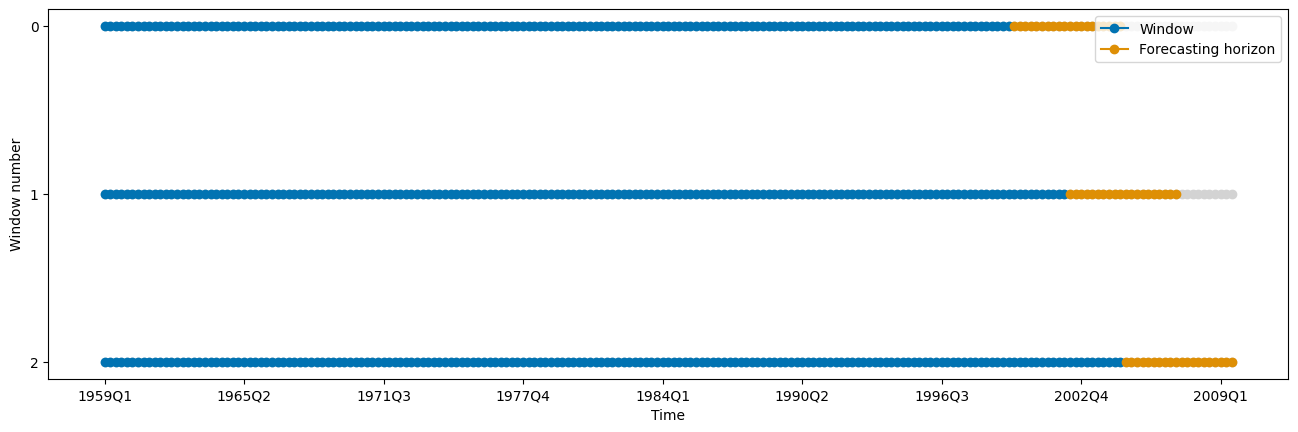

In [73]:
# Define cross-validation splitter
window_length_cv = 4 * window_length + 3
cv = ExpandingWindowSplitter(fh=fh_permuter, initial_window=window_length_cv, step_length=10)
plot_windows(cv=cv, y=y);

In [76]:
# # Run the search
# gscv = ForecastingGridSearchCV(
#     forecaster=pipeline_multi_permuted,
#     param_grid=param_grid_permute,
#     cv=cv,
#     scoring=MeanSquaredError(square_root=True),
#     error_score=np.nan,
#     backend=None,
#     verbose=1
# )
# gscv.fit(y=y, X=X, fh=fh)

# Fitting 3 folds for each of 7168 candidates, totalling 21504 fits

# # Print best parameters
# print("Best Parameters:")
# print(pd.Series(gscv.best_params_))

# # Print best score
# print("\nBest Score:")
# print(gscv.best_score_)

# Splitters

In [33]:
# Function to create cross-validation splitter based on desired number of splits
def create_splitter(y, num_splits, splitter_type='expanding', fh=1):
    """
    Create a time series cross-validation splitter for sktime.

    Parameters:
    y (array-like): The time series data.
    num_splits (int): The number of splits to create.
    splitter_type (str): The type of splitter ('expanding' or 'sliding').
    fh (int or array-like): The forecasting horizon.

    Returns:
    cv (object): The sktime splitter object.
    """
    n_samples = len(y)

    # If fh is a list, use the maximum value for calculations
    if isinstance(fh, (list, np.ndarray)):
        max_fh = max(fh)
    else:
        max_fh = fh

    # Calculate step_length based on the desired number of splits
    step_length = (n_samples - max_fh) // num_splits

    if splitter_type == 'expanding':
        initial_window = n_samples - max_fh - (num_splits - 1) * step_length
        cv = ExpandingWindowSplitter(fh=fh, initial_window=initial_window, step_length=step_length)
    elif splitter_type == 'sliding':
        window_length = n_samples - max_fh - (num_splits - 1) * step_length
        cv = SlidingWindowSplitter(fh=fh, window_length=window_length, step_length=step_length)
    else:
        raise ValueError("splitter_type must be either 'expanding' or 'sliding'")

    return cv

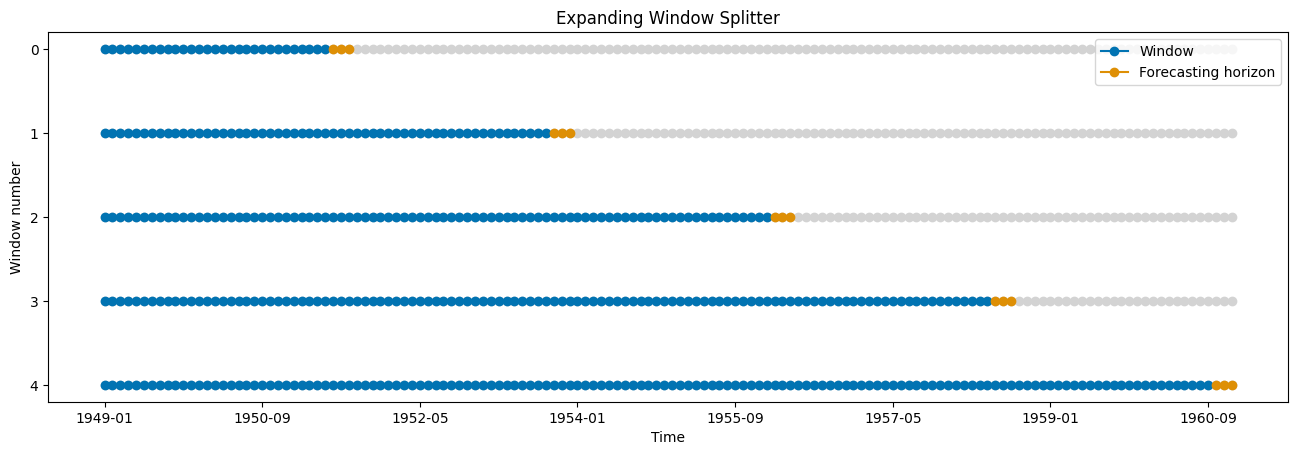

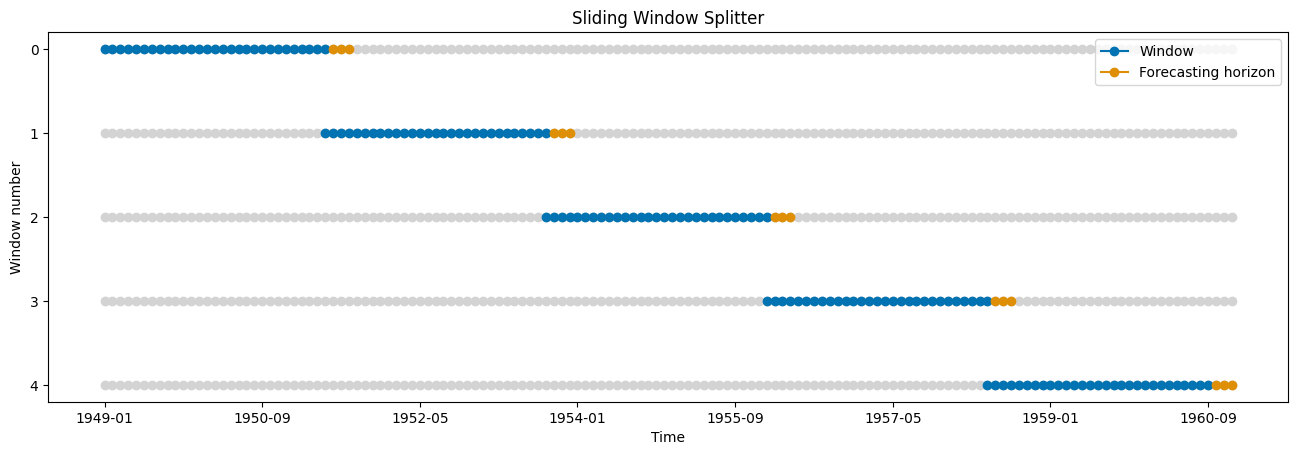

In [34]:
import matplotlib.pyplot as plt
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_windows

# Load the data
y = load_airline()
num_splits = 5
fh = [1, 2, 3]

# Expanding Window Splitter
cv_expanding = create_splitter(y, num_splits, splitter_type='expanding', fh=fh)
plot_windows(cv=cv_expanding, y=y)
plt.title('Expanding Window Splitter')
plt.show()

# Sliding Window Splitter
cv_sliding = create_splitter(y, num_splits, splitter_type='sliding', fh=fh)
plot_windows(cv=cv_sliding, y=y)
plt.title('Sliding Window Splitter')
plt.show()